In [30]:
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Layer
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dropout, Dense, LSTM, Concatenate, Flatten, Conv1D
from tensorflow.keras.models import Sequential
from kerashypetune import KerasGridSearch
from models import T2V



from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot

In [31]:
class Sine(tf.keras.layers.Layer):
    def __init__(self, w0: float = 1.0, **kwargs):
        """
        Sine activation function with learnable w0 scaling support.
        Args:
            w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`
        """
        super(Sine, self).__init__(**kwargs)
        #self.w0 = w0
    
    def build(self, input_shape):
        self.w0 = self.add_weight(shape=(1,),
                             initializer='ones',
                             trainable=True)

    def call(self, inputs):
        return tf.sin(self.w0 * inputs)
    
    def get_config(self):
        config = {'w0': self.w0}
        base_config = super(Sine, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [32]:
def Neural_time2vec():
    inp = layers.Input(shape=(128,9))
    x1 = LSTM(32, activation='relu')(inp)
    x1 = Dense(64)(x1)
    x1 = Dense(32)(x1)
    x2 = LSTM(32)(inp)
    x2 = Sine()(x2)
    x2 = Dense(64)(x2)
    x2 = Sine()(x2)
    x2 = Dense(32)(x2)
    x2 = Sine()(x2)
    x = Concatenate()([x1, x2])
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    model.compile(loss='mse', optimizer='adam')
    #model.summary()
    #tf.keras.utils.plot_model(model, show_shapes=True)
    return model

In [33]:
def time2vec_lstm_baseline():
    inp = layers.Input(shape=(128, 9))
    x = T2V(64)(inp)
    x = LSTM(32, activation='relu')(x)
    x = Dense(64)(x)
    x = Dense(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    model.compile(loss='mse', optimizer='adam')
    #model.summary()
    #tf.keras.utils.plot_model(model, show_shapes=True)
    return model

In [34]:
def lstm_baseline():
    inp = layers.Input(shape=(128, 9))
    x = LSTM(32, activation='relu')(inp)
    x = Dense(64)(x)
    x = Dense(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    model.compile(loss='mse', optimizer='adam')
    #model.summary()
    #tf.keras.utils.plot_model(model, show_shapes=True)
    return model

# Experiment 1: Low-volatile Stock price prediction (PepsiCo) - 2 year data

In [35]:
lstm_model = lstm_baseline()

In [36]:
time2vec_model = time2vec_lstm_baseline()

In [37]:
neural_time2vec_model = Neural_time2vec()

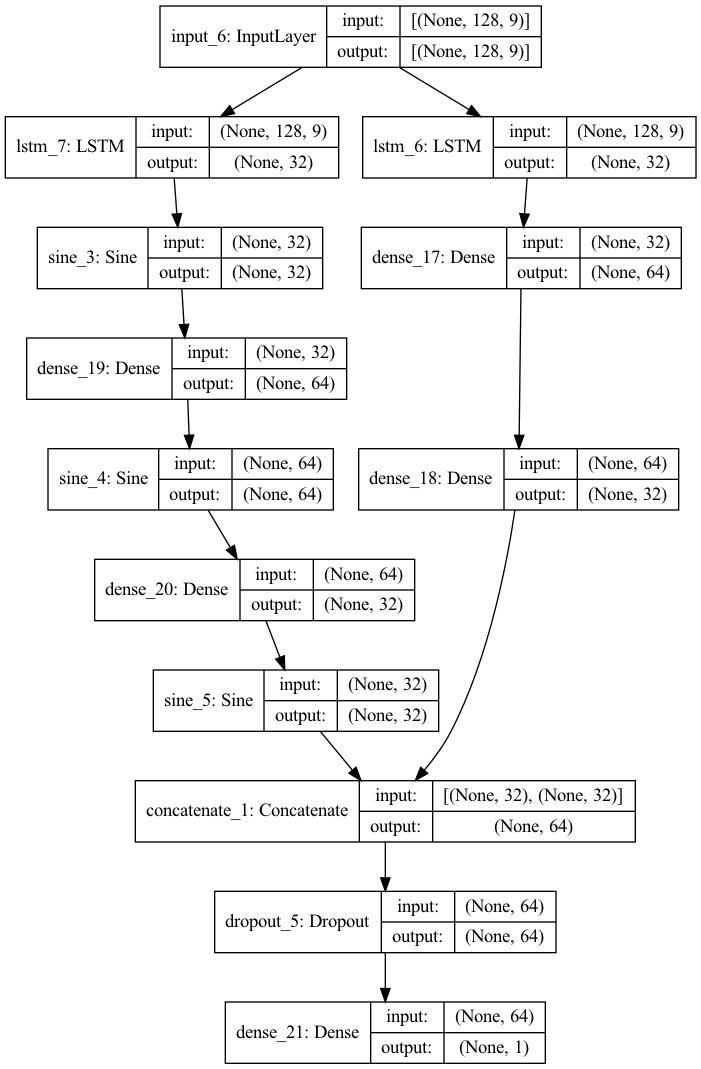

In [38]:
tf.keras.utils.plot_model(neural_time2vec_model, show_shapes=True)

In [39]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data
#from data import RealtimeFinanceData

In [40]:
# data_instance = RealtimeFinanceData(name="PEP", from_date="2020-01-01")
# data_instance.plot_close_price()
# X_train, X_test, y_train, y_test = data_instance.generate_data(SEQ_LEN=50)

In [41]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            pyplot.title('activity '+str(act_id), y=0, loc='left')
    pyplot.show()

In [42]:
# load all train
X_train, y_train = load_dataset('train', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_train.shape, y_train.shape)

# load all test
X_test, y_test = load_dataset('test', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [43]:
# Training
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, validation_split=0.2, shuffle=False, batch_size=16, verbose=1)

Epoch 1/10
368/368 [==============================] - 9s 23ms/step - loss: 4.6355 - val_loss: 1.2017
Epoch 2/10
368/368 [==============================] - 8s 22ms/step - loss: 0.7287 - val_loss: 0.8581
Epoch 3/10
368/368 [==============================] - 9s 23ms/step - loss: 0.5177 - val_loss: 0.6959
Epoch 4/10
368/368 [==============================] - 9s 24ms/step - loss: 0.4230 - val_loss: 0.5526
Epoch 5/10
368/368 [==============================] - 9s 24ms/step - loss: 0.3622 - val_loss: 0.5260
Epoch 6/10
368/368 [==============================] - 9s 24ms/step - loss: 0.3077 - val_loss: 0.5109
Epoch 7/10
368/368 [==============================] - 9s 24ms/step - loss: 0.3827 - val_loss: 0.5670
Epoch 8/10
368/368 [==============================] - 9s 24ms/step - loss: 493.7973 - val_loss: 1.3392
Epoch 9/10
368/368 [==============================] - 9s 24ms/step - loss: 1.1834 - val_loss: 1.1062
Epoch 10/10
368/368 [==============================] - 9s 24ms/step - loss: 1.0608 - val_

In [44]:
history_t2v = time2vec_model.fit(X_train, y_train, epochs=10, validation_split=0.2, shuffle=False, batch_size=16, verbose=1)


Epoch 1/10
368/368 [==============================] - 11s 28ms/step - loss: 499433.5884 - val_loss: 5.0712
Epoch 2/10
368/368 [==============================] - 10s 27ms/step - loss: 4.4408 - val_loss: 3.7601
Epoch 3/10
368/368 [==============================] - 10s 27ms/step - loss: 3.4944 - val_loss: 3.3369
Epoch 4/10
368/368 [==============================] - 10s 27ms/step - loss: 3.2813 - val_loss: 3.1978
Epoch 5/10
368/368 [==============================] - 10s 26ms/step - loss: 3.1662 - val_loss: 3.0968
Epoch 6/10
368/368 [==============================] - 9s 26ms/step - loss: 3.0432 - val_loss: 2.9969
Epoch 7/10
368/368 [==============================] - 10s 27ms/step - loss: 2.9334 - val_loss: 2.8991
Epoch 8/10
368/368 [==============================] - 10s 27ms/step - loss: 2.8583 - val_loss: 2.8040
Epoch 9/10
368/368 [==============================] - 10s 27ms/step - loss: 2.8176 - val_loss: 2.6794
Epoch 10/10
368/368 [==============================] - 10s 27ms/step - loss: 2

In [45]:
history_neural_t2v = neural_time2vec_model.fit(X_train, y_train, epochs=10, validation_split=0.2, shuffle=False, batch_size=16, verbose=1)

Epoch 1/10
368/368 [==============================] - 12s 30ms/step - loss: 4.2753 - val_loss: 302742896640.0000
Epoch 2/10
368/368 [==============================] - 11s 30ms/step - loss: 1.1985 - val_loss: 0.9472
Epoch 3/10
368/368 [==============================] - 11s 31ms/step - loss: 0.5427 - val_loss: 0.6587
Epoch 4/10
368/368 [==============================] - 11s 31ms/step - loss: 0.3915 - val_loss: 0.6297
Epoch 5/10
368/368 [==============================] - 11s 30ms/step - loss: 0.3323 - val_loss: 0.6076
Epoch 6/10
368/368 [==============================] - 11s 30ms/step - loss: 0.3284 - val_loss: 0.6007
Epoch 7/10
368/368 [==============================] - 11s 30ms/step - loss: 0.3127 - val_loss: 0.5471
Epoch 8/10
368/368 [==============================] - 11s 30ms/step - loss: 0.2834 - val_loss: 0.5633
Epoch 9/10
368/368 [==============================] - 11s 30ms/step - loss: 0.2482 - val_loss: 0.5691
Epoch 10/10
368/368 [==============================] - 11s 30ms/step - 

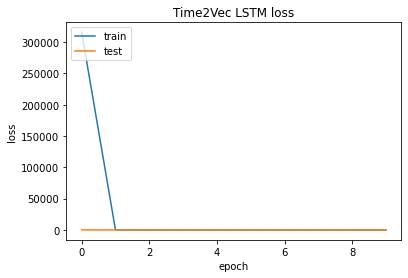

In [46]:
plt.plot(history_t2v.history['loss'])
plt.plot(history_t2v.history['val_loss'])
plt.title('Time2Vec LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

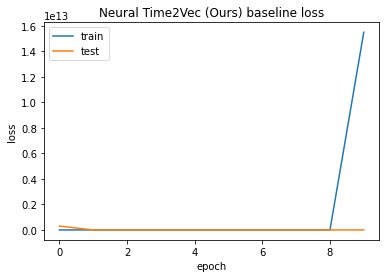

In [47]:
plt.plot(history_neural_t2v.history['loss'])
plt.plot(history_neural_t2v.history['val_loss'])
plt.title('Neural Time2Vec (Ours) baseline loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

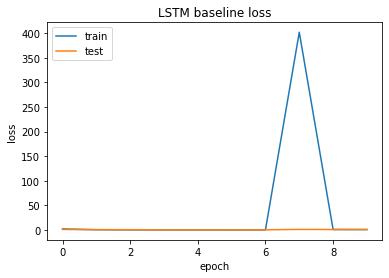

In [48]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM baseline loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
lstm_model.evaluate(X_test, y_test)

93/93 [==============================] - 1s 6ms/step - loss: 1.0440


1.0439904928207397

In [50]:
time2vec_model.evaluate(X_test, y_test)

93/93 [==============================] - 1s 7ms/step - loss: 2.1098


2.1097662448883057

In [51]:
neural_time2vec_model.evaluate(X_test, y_test)

93/93 [==============================] - 1s 7ms/step - loss: 180.0665


180.06651306152344

In [52]:
item = "HAR DATASET"

In [53]:
def predict_and_plot(model, X_test, model_name, item):
    y_hat = model.predict(X_test)
    plt.plot(y_test, label=f"Actual {item}", color='green')
    plt.plot(y_hat, label=f"Predicted {item}", color='red')

    plt.title(f'{item} prediction with {model_name}')
    plt.xlabel('Time [days]')
    plt.ylabel(f'{item}')
    plt.legend(loc='best')
    plt.show()

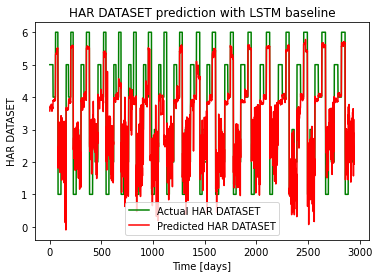

In [54]:
predict_and_plot(lstm_model, X_test, "LSTM baseline", item)

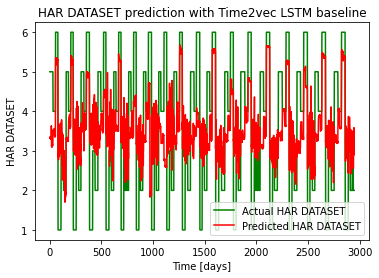

In [55]:
predict_and_plot(time2vec_model, X_test, "Time2vec LSTM baseline", item)

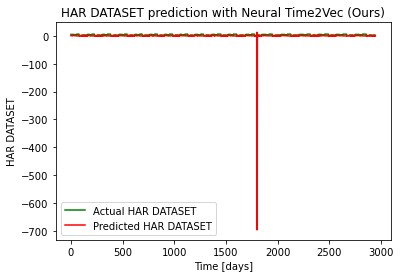

In [56]:
predict_and_plot(neural_time2vec_model, X_test, "Neural Time2Vec (Ours)", item)

### Inference 1: 

**This low training data case shows that few-shot time series forecasting is not possible with embeddings that start from scratch. To make it a reality, we need to develop pre-trained embeddings for Time-series**

In [ ]:
model.summary()